# Project: Teaching an LLM to Reason

In this project, you will teach an LLM to use step-by-step reasoning to answer the question: "How many X's are there in the word Y?"

Counting letters in a word is a surprisingly complex task for an LLM. Just as human beings would not be able to answer such a question for longer words without breaking down the word into its individual letters and then counting them, LLMs cannot be similarly expected to be able to respond without using smaller reasoning steps.

For example, to count the number of o's in the word room, one could use the following reasoning:

```
Question: How many of the letter "o" are there in the word "room"
Answer: 2
Response:

<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
```

In this project we will use the reinforcement learning method GRPO (Group Relative Policy Optimization, of DeepSeek fame) to take a large language model that has been fine-tuned for following instructions and teach it how to break a word down into its letters and then count the requested letter.

We will complete the following steps:

* Set up the notebook
* Create a letter-counting dataset
* Create the reward functions
* Train the model
* View the results

NOTE: This notebook will have you focus on several important aspects of training a GPRO model using LoRA:

1. Configuring LoRA adapters for parameter-efficient fine tuning
2. Selecting reward functions that help the model efficiently find its way to the correct answer (also called reward shaping)
3. Finding hyperparameters that help the model increase the rewards earned more quickly and reliably
4. Learning how to start with smaller experiments and to work your way up to longer experiments.

## Set up the notebook

We'll install dependencies needed for the project, namely `unsloth` and `vllm`, which are useful for fine-tuning LLMs with even just 15GB of VRAM.

In [46]:
# Load ipython-autotime to see how long each cell take to run
# No changes needed in this cell

!pip install -q ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.23 s (started: 2026-01-01 03:54:03 +00:00)


In [47]:
# Verify we have enough GPU memory to run this project (at least 15360MiB)
# No changes needed in this cell

!nvidia-smi

Thu Jan  1 03:54:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0             24W /   70W |    6391MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

time: 331 ms (started: 2026-01-01 03:54:06 +00:00)


In [48]:
# Load the `Qwen 2.5 3B Instruct`, and set parameters for the project
# The first time unsloth is imported, it will do its magic and patch the modules
# it works with. This may 2-5 minutes.

import unsloth
from unsloth import FastLanguageModel
import torch

max_seq_length = 384  # Increase if you get errors about the sequence length

# Set the LoRA rank (must be one of: 8, 16, 32, 64, 128)
# Chọn 64 vì cân bằng tốt giữa chất lượng học và VRAM cho model 3B trên GPU ~16GB.
lora_rank = 64

# Load the Instruct model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,      # We'll use quantization!
    fast_inference=False,   # ✅ Tắt vLLM để tránh lỗi thiếu vllm / xung đột môi trường
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.5,  # Reduce (e.g. 0.4) if you get OOM
)

# Choose adapters/target modules for LoRA
# Bao phủ attention projections + MLP projections để học tốt hành vi suy luận theo bước.
target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=target_modules,
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Unsloth enables longer contexts
    # See: https://github.com/unslothai/unsloth
)


==((====))==  Unsloth 2025.12.9: Fast Qwen2 patching. Transformers: 4.57.3. vLLM: 0.13.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
time: 20.9 s (started: 2026-01-01 03:54:07 +00:00)


## Try Prompt Engineering to Count Letters

Let's work on the system prompt a little to see if we can get the model to count the number of the letter `g` in `engage`.


Here you must:
* Write clear instructions
* Break the problem down into steps (Chain-of-Thought prompting)
* Provide at least one example for the model to follow (Few-shot prompting)

In [49]:
# First, let's see what happens when we have a blank system prompt
# (Fixed: run with Transformers generate instead of vLLM fast_generate)

SYSTEM_PROMPT = ""
USER_PROMPT = 'How many of the letter "g" are there in the word "engage"?'

# Convert messages to a single string
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT},
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Generate with Transformers (no vLLM)
inputs = tokenizer([text_for_completion], return_tensors="pt").to(model.device)

with torch.inference_mode():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.8,
        top_p=0.95,
    )

# Only decode the newly generated tokens (clean output)
new_tokens = outputs[0, inputs["input_ids"].shape[1]:]
generated = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT (assistant only) ===")
print(generated)


=== TEXT FOR COMPLETION ===
<|im_start|>system
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"?<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT (assistant only) ===
In the word "engage", there is only one letter "g".
time: 1.2 s (started: 2026-01-01 03:54:27 +00:00)


Without any prompting the model will generate an output such as this:

```
=== GENERATED OUTPUT ===
There is one letter "g" in the word "engage".
```

Now let's work on the system prompt to help the model break this problem down into steps, which might help it get the right answer (2 `g`'s in `engage`)

In [50]:
# Let's work on a new system prompt that will help the model break this problem
# down into steps, for example, using "letter-by-letter" spelling.

import torch

SYSTEM_PROMPT = """You are a helpful assistant that counts letters in words step-by-step.

Rules:
1) Spell the word letter-by-letter in order.
2) For each letter, say whether it matches the target letter and keep a running total.
3) Return the final count.

Use this exact format:
<reasoning>
1) <letter> -> <match/not match>, total = <number>
2) ...
</reasoning>
<answer>
<number>
</answer>

Example:
Question: How many "o" are there in the word "room"?

<reasoning>
1) r -> not "o", total = 0
2) o -> match, total = 1
3) o -> match, total = 2
4) m -> not "o", total = 2
</reasoning>
<answer>
2
</answer>
"""

USER_PROMPT = 'How many of the letter "g" are there in the word "engage"?'

# Build the chat prompt text
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT},
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Generate with Transformers (no vLLM)
inputs = tokenizer([text_for_completion], return_tensors="pt").to(model.device)

with torch.inference_mode():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.8,
        top_p=0.95,
    )

# Only decode the newly generated tokens (clean output)
new_tokens = outputs[0, inputs["input_ids"].shape[1]:]
generated = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT (assistant only) ===")
print(generated)


=== TEXT FOR COMPLETION ===
<|im_start|>system
You are a helpful assistant that counts letters in words step-by-step.

Rules:
1) Spell the word letter-by-letter in order.
2) For each letter, say whether it matches the target letter and keep a running total.
3) Return the final count.

Use this exact format:
<reasoning>
1) <letter> -> <match/not match>, total = <number>
2) ...
</reasoning>
<answer>
<number>
</answer>

Example:
Question: How many "o" are there in the word "room"?

<reasoning>
1) r -> not "o", total = 0
2) o -> match, total = 1
3) o -> match, total = 2
4) m -> not "o", total = 2
</reasoning>
<answer>
2
</answer>
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"?<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT (assistant only) ===
<reasoning>
1) e -> not "g", total = 0
2) n -> not "g", total = 0
3) g -> match, total = 1
4) a -> not "g", total = 1
5) n -> not "g", total = 1
6) g -> match, total = 2
</reasoning>
<answer>
2
</answer>


Did your new prompt get the right answer? Did the model follow all of your instructions?

Maybe yes, maybe no. Either way, we'll want the model to reliably complete this challenge. So let's use GRPO to help it!

## Create a letter-counting dataset

To train a model, we'll first need to create a dataset. We'll use the HuggingFace `datasets` package.

In [51]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]

print(len(ALL_WORDS))

ALL_WORDS[:10]

62


['idea',
 'glow',
 'rust',
 'maze',
 'echo',
 'wisp',
 'veto',
 'lush',
 'gaze',
 'knit']

time: 3.8 ms (started: 2026-01-01 03:54:35 +00:00)


In [52]:
# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

{'words': 'idea', 'letters': 'a', 'counts': 1}

time: 145 ms (started: 2026-01-01 03:54:35 +00:00)


In [53]:
# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

import re
from datasets import load_dataset, Dataset

# Simple CoT prompt (zero-shot)
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

ds = ds.map(
    lambda x: {  # type: ignore
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

ds[0]

{'words': 'idea',
 'letters': 'a',
 'counts': 1,
 'prompt': [{'content': "\nRespond in the following format:\n<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. [first letter] - [count of requested letter so far] so far\n2. [second letter] - [count of requested letter so far] so far\n...\n</reasoning>\n<answer>\n[number]\n</answer>\n",
   'role': 'system'},
  {'content': 'How many of the letter "a" are there in the word "idea"',
   'role': 'user'}]}

time: 23.6 ms (started: 2026-01-01 03:54:35 +00:00)


In [54]:
needed = [
    "extract_letter_numbering",
    "numbering_reward_func",
    "spelling_reward_func",
    "counting_reward_func",
    "format_reward_func",
    "correct_answer_reward_func",
]
print({n: (n in globals()) for n in needed})


{'extract_letter_numbering': True, 'numbering_reward_func': True, 'spelling_reward_func': True, 'counting_reward_func': True, 'format_reward_func': True, 'correct_answer_reward_func': True}
time: 25.2 ms (started: 2026-01-01 03:54:35 +00:00)


In [55]:
# 0) Bảo đảm có model/tokenizer (nếu kernel mới)
try:
    model, tokenizer
except NameError:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="Qwen/Qwen2.5-3B-Instruct",
        max_seq_length=2048,
        load_in_4bit=True,
        dtype=None,
        device_map="auto",
    )

# 1) Bảo đảm dataset đã tạo
if "ds" not in globals():
    raise RuntimeError("Dataset `ds` chưa có. Chạy các cell tạo dataset (ALL_WORDS → generate_records → ds.map).")

# 2) Chuẩn hoá prompt thành danh sách messages
p = ds[0]["prompt"]
if isinstance(p, list):
    messages = p
elif isinstance(p, dict) and "messages" in p:
    messages = p["messages"]
elif isinstance(p, str):
    messages = [{"role": "system", "content": ""}, {"role": "user", "content": p}]
else:
    raise TypeError(f"Không hiểu kiểu prompt: {type(p)}")

# 3) Áp chat template để ra chuỗi text
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# 4) Dùng model.generate (ổn định hơn fast_generate)
import torch
inputs = tokenizer([text], return_tensors="pt").to(model.device)

with torch.no_grad():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.95,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id
    )

# 5) Giải mã phần sinh mới
gen_text = tokenizer.decode(gen_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
print(gen_text)


<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 1 so far
3. e - 2 so far
4. a - 3 so far
</reasoning>
<answer>
3
</answer>
time: 4.6 s (started: 2026-01-01 03:54:35 +00:00)


## Create Reward Functions

One goal of creating reward functions is to guide the model toward behaviors that help it reach its goal (counting the occurrences of a letter within a word) more easily. Since there is more than one way to carry out any step-by-step task (e.g. whether or not you use bullet points to separate your steps), there's a bit of judgement involved in choosing what behaviors to reward, i.e. how do we provide partial credit or "shape" our rewards?

In this case we will encourage the model to (whether or not this structure is best):
* use numbers for bullet points when spelling out the word
* to spell the word correctly
* to count the requested letter correctly
* to use the requested reasoning format
* to get the final answer correct.


### Numbering reward function

In [56]:
# ==== Reward suite + GRPO params (one-shot paste) =================================

# Helper: extract numbering at start of each reasoning line (e.g., "1. g - 1 so far")
def extract_letter_numbering(response: str) -> list[int]:
    """
    Returns [1,2,...] from lines like:
      1. g - 1 so far
      2) o - 1 so far
    """
    import re
    pattern = r"(?m)^\s*(\d+)[\.\)]\s*[A-Za-z]"
    matches = re.findall(pattern, response)
    return [int(m) for m in matches] if matches else []

# 1) Numbering reward --------------------------------------------------------------
def numbering_reward_func(completions, words, **kwargs) -> list[float]:
    """
    Reward good 1..n numbering; penalize out-of-order and going past len(word).
    Normalized by word length.
    """
    responses = [completion[0]["content"] for completion in completions]
    res = []
    for response, word in zip(responses, words):
        reward = 0.0
        nums = extract_letter_numbering(response)
        for ix, spell_number in enumerate(nums):
            line_number = ix + 1
            reward += 1.0 if spell_number == line_number else -1.0
            if line_number > len(word):
                reward -= 2.0
        res.append(reward / max(1, len(word)))
    return res

# 2) Spelling reward ---------------------------------------------------------------
def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """
    +2.0 if exact spelling (order & length).
    -1.0 per extra letter; -0.5 per missing letter; -0.2 per position mismatch when lengths match.
    """
    import re
    responses = [completion[0]["content"] for completion in completions]
    res = []
    for response, word in zip(responses, words):
        # From lines "1. g - ..." capture 'g'
        letters = re.findall(r"(?m)^\s*\d+[\.\)]\s*([A-Za-z])", response)
        target = list(word)
        score = 0.0
        if letters == target:
            score += 2.0
        diff = len(letters) - len(target)
        if diff > 0:
            score -= 1.0 * diff          # extra letters
        elif diff < 0:
            score -= 0.5 * (-diff)        # missing letters
        if len(letters) == len(target):
            mism = sum(1 for a, b in zip(letters, target) if a != b)
            score -= 0.2 * mism
        res.append(score)
    return res

# 3) Counting reward ---------------------------------------------------------------
def counting_reward_func(completions, words, letters, **kwargs) -> list[float]:
    """
    +1 if running_total is correct at each parsed step, -1 otherwise.
    Normalized by number of parsed steps; -1.0 if no steps parsed.
    """
    import re
    responses = [completion[0]["content"] for completion in completions]
    res = []
    for response, word, target_letter in zip(responses, words, letters):
        tgt = target_letter.lower()
        # Capture (letter_at_step, total=N). Accepts spaces: "total = 2" or "total=2"
        steps = re.findall(
            r"(?mi)^\s*\d+[\.\)]\s*([A-Za-z]).*?total\s*=\s*(\d+)",
            response,
        )
        running = 0
        scores = []
        for i, (ch, tot) in enumerate(steps, start=1):
            if i > len(word):
                # Over-length penalized by numbering reward; skip here
                continue
            running += 1 if word[i-1].lower() == tgt else 0
            predicted = int(tot)
            scores.append(1.0 if predicted == running else -1.0)
        score = (sum(scores) / len(scores)) if scores else -1.0  # [-1,1]
        res.append(1.0 * score)  # scale=1.0
    return res

# 4) Format reward -----------------------------------------------------------------
def format_reward_func(completions, **kwargs) -> list[float]:
    """
    +0.5 if <reasoning>...</reasoning> exists; +0.5 if <answer> has a digit.
    """
    import re
    responses = [completion[0]["content"] for completion in completions]
    res = []
    for response in responses:
        score = 0.0
        if re.search(r"<reasoning>.*?</reasoning>", response, re.S):
            score += 0.5
        if re.search(r"<answer>\s*\d+\s*</answer>", response):
            score += 0.5
        res.append(score)
    return res

# 5) Final correctness reward ------------------------------------------------------
def correct_answer_reward_func(completions, words, letters, **kwargs) -> list[float]:
    """
    +2.0 if final answer equals true count; -1.0 otherwise or if not extracted.
    """
    import re
    responses = [completion[0]["content"] for completion in completions]
    res = []
    for response, word, target_letter in zip(responses, words, letters):
        m = re.search(r"<answer>\s*(\d+)\s*</answer>", response)
        if not m:
            res.append(-1.0)
            continue
        pred = int(m.group(1))
        truth = sum(1 for ch in word if ch.lower() == target_letter.lower())
        res.append(2.0 if pred == truth else -1.0)
    return res

# ==== GRPO common training params =================================================
COMMON_GRPO_TRAINING_PARAMS = dict(
    learning_rate = 1e-5,          # ≈ 10e-6 như gợi ý
    beta = 1e-4,
    per_device_train_batch_size = 16,
    num_generations = 4,
    gradient_accumulation_steps = 1,
    use_vllm = True,               # nếu môi trường không hỗ trợ vLLM -> đổi False
)
# =================================================================================


time: 4.25 ms (started: 2026-01-01 03:54:40 +00:00)


### Spelling reward function

In [57]:
# ---------------------------------------------------------
# Spelling reward function
# ---------------------------------------------------------
# Goal: reward responses that spell the word letter-by-letter correctly
# and in the right order (1..len(word)), and penalize extra/missing/wrong letters.

import re

def extract_spelled_letters(response: str) -> list[str]:
    """
    Extract the spelled letters from lines like:
    1. g - 1 so far
    2. o - 1 so far
    Returns ["g","o",...]
    Works even if there are extra spaces or text after the letter.
    """
    # Start-of-line OR after newline, number dot, spaces, then a single a-z letter
    pattern = r"(?:^|\n)\s*\d+\.\s*([a-z])\b"
    return re.findall(pattern, response.lower())


def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """
    Reward:
      +1  for each correct letter at the correct position
      -1  for wrong letter at a position
      -0.5 for missing positions (too short)
      -1  per extra letter beyond word length (too long)
    Normalize by len(word).
    """
    responses = [completion[0]["content"] for completion in completions]

    res = []
    for response, word in zip(responses, words):
        word = word.lower().strip()
        spelled = extract_spelled_letters(response)

        reward = 0.0

        # Compare position-by-position for the length of the word
        for i, true_letter in enumerate(word):
            if i < len(spelled):
                if spelled[i] == true_letter:
                    reward += 1.0
                else:
                    reward -= 1.0
            else:
                # missing a letter line
                reward -= 0.5

        # Penalize extra letters beyond the word length
        if len(spelled) > len(word):
            reward -= 1.0 * (len(spelled) - len(word))

        res.append(reward / max(1, len(word)))
    return res


# -------------------- Test --------------------
res = spelling_reward_func(
    completions=[
        [
            {  # Worse response: extra + wrong ordering/letters
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
5. x - 2 so far
</reasoning>
<answer>2</answer>"""
            },
        ],
        [
            {  # Better response: correct spelling for "goal"
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
</reasoning>
<answer>2</answer>"""
            },
        ],
    ],
    words=["goal", "goal"],
)
print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[0.75, 1.0]
time: 44.7 ms (started: 2026-01-01 03:54:40 +00:00)


### Counting reward function

In [58]:
# -----------------------------
# Counting reward function (FIXED)
# -----------------------------

import re

def extract_answer_int(response: str):
    """
    Try to extract the integer inside:
    <answer>
    2
    </answer>
    Fallback: first standalone integer found.
    """
    # Primary: <answer>...</answer>
    m = re.search(r"<answer>\s*([0-9]+)\s*</answer>", response, flags=re.IGNORECASE | re.DOTALL)
    if m:
        return int(m.group(1))

    # Fallback: any integer
    m2 = re.search(r"\b([0-9]+)\b", response)
    if m2:
        return int(m2.group(1))

    return None


def extract_reasoning_lines(response: str):
    """
    Extract lines like:
    1. e - ... total = 1
    or
    1) e -> ... total = 1
    Returns list of tuples: (line_no:int, letter:str, total:int or None)
    """
    lines = []
    # Match both "1." and "1)" styles, capture letter and optional total
    pattern = re.compile(
        r"^\s*(\d+)[\.\)]\s*([a-zA-Z])\b.*?(?:total\s*=\s*([0-9]+)|so\s*far\s*[:=]?\s*([0-9]+))?",
        flags=re.IGNORECASE,
    )

    for raw in response.splitlines():
        m = pattern.search(raw)
        if not m:
            continue
        n = int(m.group(1))
        letter = m.group(2).lower()
        total = None
        if m.group(3) is not None:
            total = int(m.group(3))
        elif m.group(4) is not None:
            total = int(m.group(4))
        lines.append((n, letter, total))
    return lines


def counting_reward_func(completions, words, letters, **kwargs) -> list[float]:
    """
    Reward focuses on:
    - Having a parsable answer
    - Answer correctness (main)
    - Bonus if it spells at least some lines with numbering
    Always returns a list with len == len(completions).
    """
    responses = [c[0].get("content", "") if isinstance(c, list) and c else "" for c in completions]

    res = []
    for response, word, target_letter in zip(responses, words, letters):
        word = str(word)
        target_letter = str(target_letter).lower()

        expected = word.lower().count(target_letter)

        ans = extract_answer_int(response)
        reasoning_lines = extract_reasoning_lines(response)

        reward = 0.0

        # 1) Answer present?
        if ans is None:
            reward -= 1.0
            res.append(reward)
            continue

        # 2) Answer correctness
        if ans == expected:
            reward += 1.0
        else:
            reward -= 1.0

        # 3) Small bonus if it attempts numbered spelling (encourage format)
        # (cap bonus to avoid dominating correctness)
        if len(reasoning_lines) > 0:
            reward += min(0.5, 0.05 * len(reasoning_lines))

        # 4) Extra small penalty if it goes way beyond word length (if numbering exists)
        if reasoning_lines:
            max_n = max(n for n, _, _ in reasoning_lines)
            if max_n > len(word) + 2:
                reward -= 0.25

        # normalize by word length to keep scale similar across examples
        reward = reward / max(1, len(word))
        res.append(reward)

    return res


# Quick self-check (should not crash, should return 2 scores)
res = counting_reward_func(
    completions=[
        [{"content": "<reasoning>\n1. e total = 1\n</reasoning>\n<answer>\n999\n</answer>"}],  # worse: wrong
        [{"content": "<reasoning>\n1. e total = 1\n2. n total = 1\n3. g total = 2\n</reasoning>\n<answer>\n2\n</answer>"}],  # better: correct for 'engage' counting 'g'
    ],
    words=["engage", "engage"],
    letters=["g", "g"],
)

print(res)
assert len(res) == 2
assert res[1] > res[0], "The better response should have a higher reward"


[-0.15833333333333333, 0.19166666666666665]
time: 41.6 ms (started: 2026-01-01 03:54:40 +00:00)


### Formatting reward functions



In [59]:
# Reward the model for providing the response in a specific format

import re

def extract_xml_answer(text: str) -> str:
    """Extracts the string between <answer> and </answer> tags."""
    pattern = r"<answer>(.*?)</answer>"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""


assert (
    extract_xml_answer("""
<reasoning>
This is my reasoning.
</reasoning>
<answer>SUPERCALIFRAGILISTICEXPIALIDOCIOUS</answer>
""")
    == "SUPERCALIFRAGILISTICEXPIALIDOCIOUS"
)


def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"\s*<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"

    res = []

    for completion in completions:
        reward = 0.0

        # Extract the response content
        response = completion[0]["content"]

        # Check if the response matches the pattern
        match = re.match(pattern, response, flags=re.MULTILINE | re.DOTALL)

        # If it matches, return 0.5, otherwise return 0.0
        if match is not None:
            reward += 0.5

        # Extract the answer from the response
        extracted_answer = extract_xml_answer(response)

        # If the answer is an integer, add 0.5 to the reward
        if re.fullmatch(r"-?\d+", extracted_answer) is not None:
            reward += 0.5

        res.append(reward)
    return res


res = format_reward_func(
    completions=[
        [{"content": "This is my answer"}],
        [
            {
                "content": "<reasoning>\nThis is my reasoning.\n</reasoning>\n<answer>\n3\n</answer>"
            }
        ],
    ]
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[0.0, 1.0]
time: 44.8 ms (started: 2026-01-01 03:54:40 +00:00)


### Task correctness reward function

In [60]:
# Reward the model for providing the correct answer

def correct_answer_reward_func(prompts, completions, counts, **kwargs) -> list[float]:
    """Reward the final answer if it is correct."""
    responses = [completion[0]["content"] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Print a nice summary of the first prompt, answer, and response to see while training
    print(f"""
{"-" * 20}
Question: {prompts[0][-1]["content"]}
Answer: {counts[0]}
Response: {responses[0]}
Extracted: {extracted_responses[0]}
Correct: {str(extracted_responses[0]).strip() == str(counts[0]).strip()}!
    """)

    # Reward: +1.0 if exactly correct, otherwise -0.5
    res = [
        1.0 if str(r).strip() == str(a).strip() else -0.5
        for r, a in zip(extracted_responses, counts)
    ]
    return res


# --- Quick self-check (make sure first is WRONG, second is RIGHT) ---
res = correct_answer_reward_func(
    prompts=[
        [{"content": """How many..."""}],
        [{"content": """How many..."""}],
    ],
    completions=[
        [{"content": """<reasoning>...</reasoning>\n<answer>\n1\n</answer>"""}],  # WRONG (should be 0)
        [{"content": """<reasoning>...</reasoning>\n<answer>\n3\n</answer>"""}],  # RIGHT (3)
    ],
    letters=["g", "g"],
    counts=[0, 3],
)

print(res)
assert res[1] > res[0], "The better response should have a higher reward"



--------------------
Question: How many...
Answer: 0
Response: <reasoning>...</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: False!
    
[-0.5, 1.0]
time: 41.4 ms (started: 2026-01-01 03:54:40 +00:00)


### List the reward functions

In [61]:
# List out the reward functions we will use
# No changes needed in this cell

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

print([f.__name__ for f in REWARD_FUNCS])


['numbering_reward_func', 'spelling_reward_func', 'counting_reward_func', 'format_reward_func', 'correct_answer_reward_func']
time: 45.2 ms (started: 2026-01-01 03:54:40 +00:00)


## Train the model

Now set up GRPO Trainer and configurations!

As you run the trainer, the goal is to see the various `reward` columns increase.

After 50 steps or more, you may notice some of the reward standard deviations begin to decrease, meaning that the different predictions are starting to converge on solutions that give similar rewards. If your model has learned the task, then you'll see the `correct_answer_reward_function` increase to its highest value (check the function to see what that is).

Here is an example, which successfully converged on a higher reward. Note, the values you see here will probably be different from yours, especially if your reward amounts are different.

| Step | Training Loss | reward   | reward_std | ... | kl      | rewards / correct_answer_reward_function / mean | rewards / correct_answer_reward_function / std |
|------|---------------|----------|------------|-----|---------|------------------------------------------|-----------------------------------------|
| 1    | 0.000000      | 7.961805 | 2.368493   | ... | 0.020369| 0.875000                                 | 1.024695                                |
| 2    | 0.000000      | 7.937500 | 1.352467   | ... | 0.016483| 0.875000                                 | 1.024695                                |
| 3    | 0.000000      | 1.894792 | 6.462189   | ... | 0.013677| 0.375000                                 | 0.806226                                |
| ...  | ...           | ...      | ...        | ... | ...     | ...                                      | ...                                     |
| 398  | 0.000100      | 13.000000| 0.000000   | ... | 0.088529| 2.000000                                 | 0.000000                                |
| 399  | 0.000100      | 13.000000| 0.000000   | ... | 0.088617| 2.000000                                 | 0.000000                                |
| 400  | 0.000100      | 13.000000| 0.000000   | ... | 0.096202| 2.000000                                 | 0.000000                                |


In [62]:
# Fill in the GRPO Parameters we'll use throughout this project
# TODO: Fill in the missing parts marked with **********

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Set appropriate values for `learning_rate` and `beta`
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    # See: https://huggingface.co/docs/trl/main/en/grpo_trainer
    # learning_rate=2e-4,
    # beta=0.1,
    # Set the batch size appropriately for your hardware. For GRPO there are a number of parameters to set.
    # If you are not sure about your GPU, assume you have a T4. See the memory specs here:
    # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-product-literature/T4%20Product%20Brief.pdf
    # per_device_train_batch_size=8,  # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider.
    # Note: Set per_device_train_batch_size to at most 16 on the Vocareum T4 for best stability
    # num_generations=4,  # Determines the number of completions/generations to compute for each single prompt
    # gradient_accumulation_steps=2,  # This parameter allow us to consider multiple steps in a single optimization step
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs",
    use_vllm=False,  # vll speeds up inference! See https://github.com/vllm-project/vllm
)

time: 47.5 ms (started: 2026-01-01 03:54:40 +00:00)


### Quick train

Let's train the model for just 5 steps (`max_steps=5`). As it runs we can double check we've set up our prompts correctly before running for a longer amount of time.

In [63]:
# Quick train (self-contained) — no need COMMON_GRPO_TRAINING_PARAMS

# --- Patch vLLM import mismatch so TRL can import
import vllm.sampling_params as sp
if not hasattr(sp, "GuidedDecodingParams"):
    class GuidedDecodingParams:
        def __init__(self, *args, **kwargs):
            pass
    sp.GuidedDecodingParams = GuidedDecodingParams

from trl import GRPOConfig, GRPOTrainer

# --- Minimal GRPO config (IMPORTANT: use_vllm=False)
training_args = GRPOConfig(
    output_dir="outputs",
    max_steps=5,

    # must be multiple of num_generations
    num_generations=2,
    per_device_train_batch_size=2,   # ✅ 2*1 divisible by 2
    gradient_accumulation_steps=1,

    max_prompt_length=256,
    max_completion_length=200,

    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=1,
    save_steps=250,
    report_to="none",

    use_vllm=False,  # CRITICAL to avoid vllm_engine issues
)
needed = [
    "numbering_reward_func",
    "spelling_reward_func",
    "counting_reward_func",
    "format_reward_func",
    "correct_answer_reward_func",
]

missing = [n for n in needed if n not in globals()]
print("Missing:", missing)

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,   # nhớ chạy cell tạo REWARD_FUNCS trước
    args=training_args,
    train_dataset=ds,
)

trainer_res = trainer.train()


Missing: []


The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. i - 1 so far (no new g's found)
3. s - 1 so far (no new g's found)
4. t - 1 so far (no new g's found)
5. e - 1 so far (no new g's found)
6. n - 1 so far (no new g's found)
7. l - 1 so far (no new g's found)
8. s - 1 so far (no new g's found)
9. g - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,2.025000,2.671854,145.500000,138.000000,153.000000,0.000000,145.500000,138.000000,153.000000,0,0,0,0,0,0.000000,0.785714,0.101015,-0.071429,1.313198,0.060714,0.196980,1.000000,0.000000,0.250000,1.060660
2,0.000000,4.300000,0.000000,82.000000,76.000000,88.000000,0.000000,82.000000,76.000000,88.000000,No Log,No Log,No Log,No Log,No Log,0.000000,1.000000,0.000000,1.000000,0.000000,0.300000,0.000000,1.000000,0.000000,1.000000,0.000000
3,0.000000,4.250000,0.000000,88.000000,87.000000,89.000000,0.000000,88.000000,87.000000,89.000000,No Log,No Log,No Log,No Log,No Log,0.000038,1.000000,0.000000,1.000000,0.000000,0.250000,0.000000,1.000000,0.000000,1.000000,0.000000
4,0.000000,3.556250,1.051821,86.000000,73.000000,99.000000,0.000000,86.000000,73.000000,99.000000,No Log,No Log,No Log,No Log,No Log,0.002234,0.875000,0.176777,0.375000,0.883883,0.306250,0.008839,1.000000,0.000000,1.000000,0.000000
5,0.000000,0.931250,0.000000,111.000000,111.000000,111.000000,0.000000,111.000000,111.000000,111.000000,No Log,No Log,No Log,No Log,No Log,0.001388,0.875000,0.000000,-0.375000,0.000000,-0.068750,0.000000,1.000000,0.000000,-0.500000,0.000000



--------------------
Question: How many of the letter "v" are there in the word "oath"
Answer: 0
Response: <reasoning>
Counting the number of v's in the word "oath"
1. o - 0 so far
2. a - 1 so far
3. t - 1 so far
4. h - 2 so far
5. - 3 so far
There is no 'v' in the word "oath".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "a" are there in the word "knack"
Answer: 1
Response: <reasoning>
1. k - 0 so far
2. n - 1 so far
3. a - 1 so far (first 'a' in "knack")
4. c - 1 so far (second 'c' in "knack")
5. k - 1 so far (third 'k' in "knack")
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "w" are there in the word "wisp"
Answer: 1
Response: <reasoning>
Counting the number of w's in the word wisp
1. w - 1 so far
2. i - 0 (no additional ws)
3. s - 1 (1st w counted)
4. p - 0 (no additional ws)
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct

In [64]:
# ---- Longer GRPO training (80–100 steps) ----
from trl import GRPOConfig, GRPOTrainer

long_args = GRPOConfig(
    output_dir="outputs_long",
    max_steps=100,                 # có thể 80 nếu muốn nhanh hơn
    num_generations=2,             # giữ 2 để an toàn VRAM (tăng 4 nếu đủ)
    per_device_train_batch_size=2, # nếu OOM -> 1
    gradient_accumulation_steps=1, # nếu OOM -> 2
    max_prompt_length=256,
    max_completion_length=200,
    learning_rate=1e-5,            # nếu reward dao động -> 5e-6
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=1,
    save_steps=250,
    report_to="none",
    use_vllm=False,                # Vocareum thường an toàn hơn khi tắt vLLM
)

long_trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=long_args,
    train_dataset=ds,
)

long_train_res = long_trainer.train()


The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 0 so far (no additional "g"s found)
3. e - 0 so far (no additional "g"s found)
4. e - 0 so far (no additional "g"s found)
5. n - 0 so far (no additional "g"s found)
6. s - 0 so far (no additional "g"s found)
7. t - 0 so far (no additional "g"s found)
8. i - 0 so far (no additional "g"s found)
9. n - 0 so far (no additional "g"s found)
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,3.060714,1.207132,152.500000,138.000000,167.000000,0.000000,152.500000,138.000000,167.000000,0,0,0,0,0,0.005845,0.785714,0.101015,0.071429,1.111168,0.203571,0.005051,1.000000,0.000000,1.000000,0.000000
2,0.000000,4.300000,0.000000,93.000000,83.000000,103.000000,0.000000,93.000000,83.000000,103.000000,No Log,No Log,No Log,No Log,No Log,0.000568,1.000000,0.000000,1.000000,0.000000,0.300000,0.000000,1.000000,0.000000,1.000000,0.000000
3,0.000000,1.160000,1.131371,93.000000,83.000000,103.000000,0.000000,93.000000,83.000000,103.000000,No Log,No Log,No Log,No Log,No Log,0.001726,0.800000,0.000000,0.000000,1.131371,-0.140000,0.000000,1.000000,0.000000,-0.500000,0.000000
4,0.000000,3.100000,1.007627,57.000000,39.000000,75.000000,0.000000,57.000000,39.000000,75.000000,No Log,No Log,No Log,No Log,No Log,0.006740,0.500000,0.353553,0.312500,0.618718,0.287500,0.035355,1.000000,0.000000,1.000000,0.000000
5,0.000000,0.931250,0.000000,111.500000,111.000000,112.000000,0.000000,111.500000,111.000000,112.000000,No Log,No Log,No Log,No Log,No Log,0.000562,0.875000,0.000000,-0.375000,0.000000,-0.068750,0.000000,1.000000,0.000000,-0.500000,0.000000
6,0.000000,0.937500,0.548008,78.500000,74.000000,83.000000,0.000000,78.500000,74.000000,83.000000,No Log,No Log,No Log,No Log,No Log,0.002790,0.625000,0.176777,0.000000,0.707107,-0.187500,0.017678,1.000000,0.000000,-0.500000,0.000000
7,0.000000,2.505000,2.467803,83.500000,83.000000,84.000000,0.000000,83.500000,83.000000,84.000000,No Log,No Log,No Log,No Log,No Log,0.002593,0.900000,0.141421,0.300000,0.989950,0.055000,0.275772,1.000000,0.000000,0.250000,1.060660
8,0.000000,2.481250,1.670540,61.500000,57.000000,66.000000,0.000000,61.500000,57.000000,66.000000,No Log,No Log,No Log,No Log,No Log,0.001772,0.875000,0.176777,0.312500,0.441942,0.043750,0.344715,1.000000,0.000000,0.250000,1.060660
9,0.000000,2.403572,0.803071,88.500000,84.000000,93.000000,0.000000,88.500000,84.000000,93.000000,No Log,No Log,No Log,No Log,No Log,0.002475,0.928571,0.101015,0.178571,0.353553,0.046429,0.196980,1.000000,0.000000,0.250000,1.060660
10,0.000000,0.562500,0.229810,97.500000,93.000000,102.000000,0.000000,97.500000,93.000000,102.000000,No Log,No Log,No Log,No Log,No Log,0.003539,0.750000,0.117851,-0.583333,0.117851,-0.104167,0.005893,1.000000,0.000000,-0.500000,0.000000



--------------------
Question: How many of the letter "v" are there in the word "oath"
Answer: 0
Response: <reasoning>
Counting the number of v's in the word "oath"
1. o - 0 so far
2. a - 1 so far (first 'a')
3. t - 2 so far (first 't')
4. h - 3 so far (first 'h')
5.  - 4 so far
So there are 0 'v's in the word "oath".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "a" are there in the word "knack"
Answer: 1
Response: <reasoning>
Counting the number of a's in the word knack
1. k - 0 so far
2. n - 1 so far
3. a - 1 (first "a") so far
4. c - 1 (first "c") so far
5. k - 1 (second "k") so far
6. n - 1 (second "n") so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "w" are there in the word "wisp"
Answer: 1
Response: <reasoning>
Counting the number of w's in the word wisp
1. w - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Corre

,rewards/numbering_reward_func/mean,rewards/spelling_reward_func/mean,rewards/counting_reward_func/mean,rewards/format_reward_func/mean,rewards/correct_answer_reward_func/mean,reward,step
91,1.000000,1.000000,0.300000,1.0,1.00,4.300000,92
92,0.937500,-0.093750,0.171875,1.0,1.00,3.015625,93
93,1.000000,0.500000,0.050000,1.0,0.25,2.800000,94
94,0.800000,-0.400000,0.260000,1.0,1.00,2.660000,95
95,0.937500,0.156250,0.046875,1.0,0.25,2.390625,96
96,1.000000,1.000000,0.216667,1.0,1.00,4.216667,97
97,0.916667,0.083333,0.220833,1.0,1.00,3.220833,98
98,0.900000,0.300000,0.055000,1.0,0.25,2.505000,99
99,1.000000,-0.571429,0.050000,1.0,0.25,1.728571,100
100,NaN,NaN,NaN,NaN,NaN,NaN,100


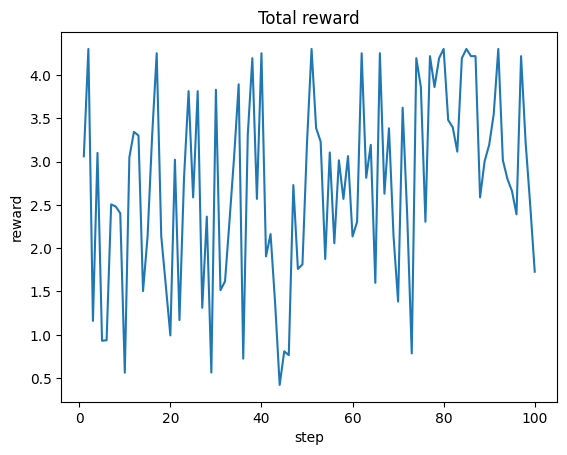

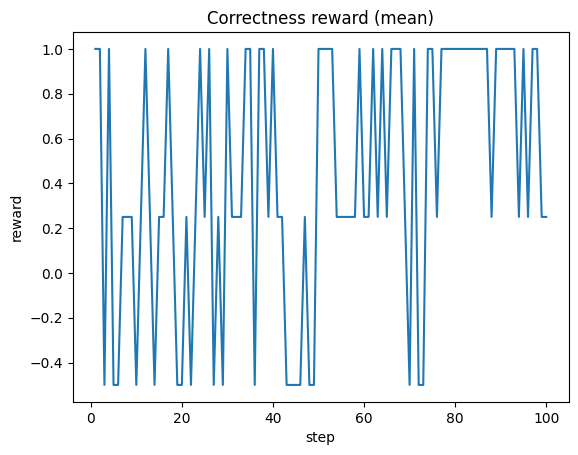

time: 321 ms (started: 2026-01-01 04:11:56 +00:00)


In [65]:
# ---- Plot reward trend ----
import pandas as pd
import matplotlib.pyplot as plt

# Lấy history từ trainer
logs = pd.DataFrame(long_trainer.state.log_history)
# Lọc những hàng có cột 'reward'
logs = logs[logs.columns.intersection([
    'step','reward',
    'rewards/numbering_reward_func/mean',
    'rewards/spelling_reward_func/mean',
    'rewards/counting_reward_func/mean',
    'rewards/format_reward_func/mean',
    'rewards/correct_answer_reward_func/mean'
])].dropna(how='all')

display(logs.tail(10))

plt.figure()
plt.plot(logs['step'], logs['reward'])
plt.title('Total reward')
plt.xlabel('step'); plt.ylabel('reward')
plt.show()

plt.figure()
col = 'rewards/correct_answer_reward_func/mean'
if col in logs:
    plt.plot(logs['step'], logs[col])
    plt.title('Correctness reward (mean)')
    plt.xlabel('step'); plt.ylabel('reward')
    plt.show()


In [66]:
# === Save LoRA adapter as safetensors ===
import os, shutil, glob

SAVE_DIR = "outputs/adapter_lora"
os.makedirs(SAVE_DIR, exist_ok=True)

# PEFT/Unsloth sẽ chỉ lưu adapter, không lưu full 3B params
# safetensors sẽ được dùng nếu gói đã có trong env
try:
    model.save_pretrained(SAVE_DIR, safe_serialization=True)
except TypeError:
    # một số bản PEFT dùng tên khác
    model.save_pretrained(SAVE_DIR, use_safetensors=True)

# lưu tokenizer (để tái dùng chat template)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved files:", os.listdir(SAVE_DIR))
print("Adapter candidate(s):", [p for p in glob.glob(os.path.join(SAVE_DIR, "*")) if p.endswith(".safetensors")])


Saved files: ['tokenizer_config.json', 'adapter_model.safetensors', 'adapter_config.json', 'merges.txt', 'special_tokens_map.json', 'chat_template.jinja', 'added_tokens.json', 'README.md', 'tokenizer.json', 'vocab.json']
Adapter candidate(s): ['outputs/adapter_lora/adapter_model.safetensors']
time: 2.86 s (started: 2026-01-01 04:11:56 +00:00)


In [67]:
# === Compare OLD (base) vs NEW (base + LoRA) on the dataset item ===
from unsloth import FastLanguageModel
import torch, copy

# 1) Tạo hàm tiện ích sinh văn bản ổn định
def generate_text(_model, _tokenizer, messages, max_new_tokens=200):
    prompt = _tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = _tokenizer([prompt], return_tensors="pt").to(_model.device)
    with torch.inference_mode():
        out_ids = _model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.3,   # hạ nhiệt cho tính nhất quán khi so sánh
            top_p=0.9,
            pad_token_id=_tokenizer.eos_token_id
        )
    new_tokens = out_ids[0, inputs["input_ids"].shape[1]:]
    return _tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

# 2) Load lại base model làm "OLD" (không gắn LoRA)
old_model, old_tok = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-3B-Instruct",
    max_seq_length = 2048,
    load_in_4bit = True,
    dtype = None,
    device_map = "auto",
)
# new_model/new_tok = current fine-tuning objects trong RAM (đã có LoRA)

# 3) Lấy một sample từ dataset letter-counting
sample = ds[0]  # bạn có thể thay index khác
messages = sample["prompt"]  # đã là list[{"role","content"}, ...]

print("== OLD (base only) ==")
old_out = generate_text(old_model, old_tok, messages)
print(old_out, "\n")

print("== NEW (base + LoRA) ==")
# NEW: dùng model/tokenizer hiện tại đã gắn LoRA
new_out = generate_text(model, tokenizer, messages)
print(new_out)

# 4) Forgetting check: hỏi kiến thức chung
question = "What is the capital of the Philippines?"
msgs_gk = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": question},
]

print("\n== OLD general knowledge ==")
print(generate_text(old_model, old_tok, msgs_gk, max_new_tokens=64))
print("\n== NEW general knowledge ==")
print(generate_text(model, tokenizer, msgs_gk, max_new_tokens=64))


==((====))==  Unsloth 2025.12.9: Fast Qwen2 patching. Transformers: 4.57.3. vLLM: 0.13.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


== OLD (base only) ==
<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 1 so far
3. e - 2 so far
4. a - 3 so far
</reasoning>
<answer>
3
</answer> 

== NEW (base + LoRA) ==
<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 0 so far
3. e - 0 so far
4. a - 1 so far
</reasoning>
<answer>
1
</answer>

== OLD general knowledge ==
The capital of the Philippines is Manila.

== NEW general knowledge ==
The capital of the Philippines is Manila.
time: 20.2 s (started: 2026-01-01 04:11:59 +00:00)


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
...


Ellipsis

time: 1.94 ms (started: 2026-01-01 04:12:19 +00:00)


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


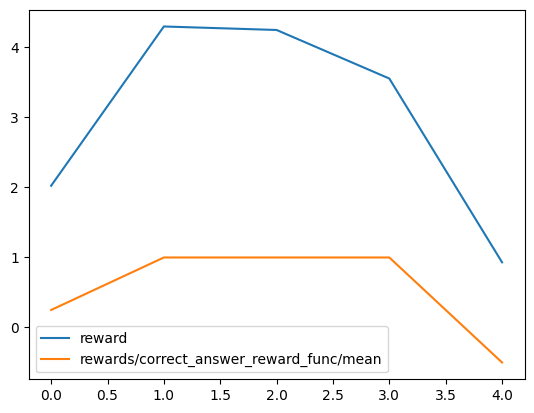

time: 189 ms (started: 2026-01-01 04:12:19 +00:00)


In [69]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

### Slower train (1+ hour)

If everything looks good, let's go for a longer training session!

In [70]:
# ---- Slower train (no vLLM) ----
# Patch vLLM import mismatch so TRL can import safely even when we don't use vLLM
import vllm.sampling_params as sp
if not hasattr(sp, "GuidedDecodingParams"):
    class GuidedDecodingParams:
        def __init__(self, *args, **kwargs): ...
    sp.GuidedDecodingParams = GuidedDecodingParams

from trl import GRPOConfig, GRPOTrainer

# Build training args (override any previous ones)
training_args = GRPOConfig(
    output_dir="outputs_long",
    max_steps=100,                 # hoặc 80 nếu muốn nhanh hơn
    num_generations=2,             # đủ VRAM thì tăng 4
    per_device_train_batch_size=2, # OOM -> 1
    gradient_accumulation_steps=1, # OOM -> 2
    max_prompt_length=256,
    max_completion_length=200,
    learning_rate=1e-5,            # nếu reward dao động: 5e-6
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=1,
    save_steps=250,
    report_to="none",
    use_vllm=False,                # <<< QUAN TRỌNG: tắt vLLM để tránh lỗi vllm_engine
)

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)

long_train_res = trainer.train()


The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 0 so far
3. i - 0 so far
4. s - 0 so far
5. t - 0 so far
6. n - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,3.582143,0.055558,88.500000,84.000000,93.000000,0.000000,88.500000,84.000000,93.000000,0,0,0,0,0,0.008009,0.928571,0.101015,0.464286,0.050508,0.189286,0.005051,1.000000,0.000000,1.000000,0.000000
2,0.000100,4.056250,0.344715,70.500000,67.000000,74.000000,0.000000,70.500000,67.000000,74.000000,No Log,No Log,No Log,No Log,No Log,0.098606,0.875000,0.176777,0.875000,0.176777,0.306250,0.008839,1.000000,0.000000,1.000000,0.000000
3,0.000100,2.350000,0.000000,74.000000,74.000000,74.000000,0.000000,74.000000,74.000000,74.000000,No Log,No Log,No Log,No Log,No Log,0.100999,1.000000,0.000000,1.000000,0.000000,-0.150000,0.000000,1.000000,0.000000,-0.500000,0.000000
4,0.000000,4.300000,0.000000,66.000000,66.000000,66.000000,0.000000,66.000000,66.000000,66.000000,No Log,No Log,No Log,No Log,No Log,0.021875,1.000000,0.000000,1.000000,0.000000,0.300000,0.000000,1.000000,0.000000,1.000000,0.000000
5,0.000100,1.053125,0.172357,106.500000,102.000000,111.000000,0.000000,106.500000,102.000000,111.000000,No Log,No Log,No Log,No Log,No Log,0.108690,0.937500,0.088388,-0.312500,0.088388,-0.071875,0.004419,1.000000,0.000000,-0.500000,0.000000
6,0.000100,3.806250,0.698268,69.500000,65.000000,74.000000,0.000000,69.500000,65.000000,74.000000,No Log,No Log,No Log,No Log,No Log,0.095013,0.875000,0.176777,0.625000,0.530330,0.306250,0.008839,1.000000,0.000000,1.000000,0.000000
7,0.000000,2.700000,2.192031,75.000000,75.000000,75.000000,0.000000,75.000000,75.000000,75.000000,No Log,No Log,No Log,No Log,No Log,0.032439,1.000000,0.000000,0.400000,0.848528,0.050000,0.282843,1.000000,0.000000,0.250000,1.060660
8,0.000000,4.300000,0.000000,66.000000,66.000000,66.000000,0.000000,66.000000,66.000000,66.000000,No Log,No Log,No Log,No Log,No Log,0.029678,1.000000,0.000000,1.000000,0.000000,0.300000,0.000000,1.000000,0.000000,1.000000,0.000000
9,0.000000,2.221428,1.464721,84.000000,84.000000,84.000000,0.000000,84.000000,84.000000,84.000000,No Log,No Log,No Log,No Log,No Log,0.012032,0.857143,0.000000,0.071429,0.202031,0.042857,0.202031,1.000000,0.000000,0.250000,1.060660
10,0.000100,1.804167,1.526172,88.500000,84.000000,93.000000,0.000000,88.500000,84.000000,93.000000,No Log,No Log,No Log,No Log,No Log,0.057594,0.916667,0.117851,-0.416667,0.117851,0.054167,0.229810,1.000000,0.000000,0.250000,1.060660



--------------------
Question: How many of the letter "v" are there in the word "oath"
Answer: 0
Response: <reasoning>
Counting the number of v's in the word oath
1. o - 0 so far
2. a - 0 so far
3. t - 0 so far
4. h - 0 so far
5. t - 0 so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "a" are there in the word "knack"
Answer: 1
Response: <reasoning>
Counting the number of a's in the word knack
1. k - 0 so far
2. n - 0 so far
3. a - 0 so far
4. c - 0 so far
5. k - 0 so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: False!
    

--------------------
Question: How many of the letter "w" are there in the word "wisp"
Answer: 1
Response: <reasoning>
Counting the number of w's in the word wisp
1. w - 1 so far
2. i - 0 so far
3. s - 0 so far
4. p - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "e" are there in the word

,step,reward,rewards/numbering_reward_func/mean,rewards/spelling_reward_func/mean,rewards/counting_reward_func/mean,rewards/format_reward_func/mean,rewards/correct_answer_reward_func/mean
91,92,4.300000,1.000000,1.000000,0.300000,1.0,1.00
92,93,3.015625,0.937500,-0.093750,0.171875,1.0,1.00
93,94,2.800000,1.000000,0.500000,0.050000,1.0,0.25
94,95,2.660000,0.800000,-0.400000,0.260000,1.0,1.00
95,96,2.390625,0.937500,0.156250,0.046875,1.0,0.25
96,97,4.216667,1.000000,1.000000,0.216667,1.0,1.00
97,98,3.220833,0.916667,0.083333,0.220833,1.0,1.00
98,99,2.505000,0.900000,0.300000,0.055000,1.0,0.25
99,100,1.728571,1.000000,-0.571429,0.050000,1.0,0.25
100,100,NaN,NaN,NaN,NaN,NaN,NaN


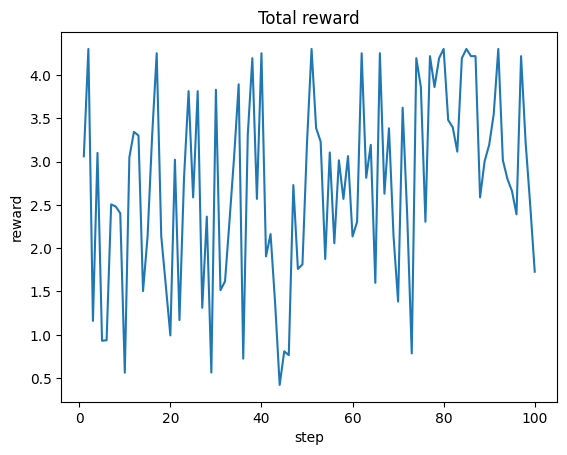

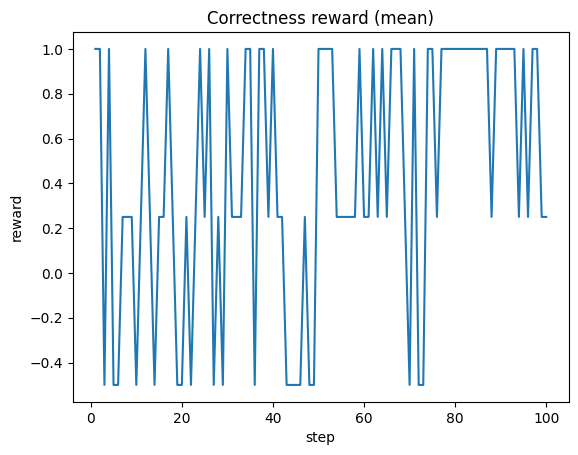

time: 291 ms (started: 2026-01-01 04:27:25 +00:00)


In [71]:
# Plot reward trends after long training
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(long_trainer.state.log_history)

keep_cols = [
    "step",
    "reward",
    "rewards/numbering_reward_func/mean",
    "rewards/spelling_reward_func/mean",
    "rewards/counting_reward_func/mean",
    "rewards/format_reward_func/mean",
    "rewards/correct_answer_reward_func/mean",
]
logs = logs[[c for c in keep_cols if c in logs.columns]].dropna(how="all")

display(logs.tail(10))

plt.figure()
plt.plot(logs["step"], logs["reward"])
plt.title("Total reward")
plt.xlabel("step"); plt.ylabel("reward")
plt.show()

col = "rewards/correct_answer_reward_func/mean"
if col in logs.columns:
    plt.figure()
    plt.plot(logs["step"], logs[col])
    plt.title("Correctness reward (mean)")
    plt.xlabel("step"); plt.ylabel("reward")
    plt.show()


In [72]:
# Save LoRA adapter + tokenizer
import os, glob
SAVE_DIR = "outputs/adapter_lora_final"
os.makedirs(SAVE_DIR, exist_ok=True)

try:
    model.save_pretrained(SAVE_DIR, safe_serialization=True)
except TypeError:
    model.save_pretrained(SAVE_DIR, use_safetensors=True)

tokenizer.save_pretrained(SAVE_DIR)
print("Saved:", os.listdir(SAVE_DIR))
print("Adapter files:", [p for p in glob.glob(f"{SAVE_DIR}/*.safetensors")])


Saved: ['tokenizer_config.json', 'adapter_model.safetensors', 'adapter_config.json', 'merges.txt', 'special_tokens_map.json', 'chat_template.jinja', 'added_tokens.json', 'README.md', 'tokenizer.json', 'vocab.json']
Adapter files: ['outputs/adapter_lora_final/adapter_model.safetensors']
time: 2.85 s (started: 2026-01-01 04:27:25 +00:00)


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


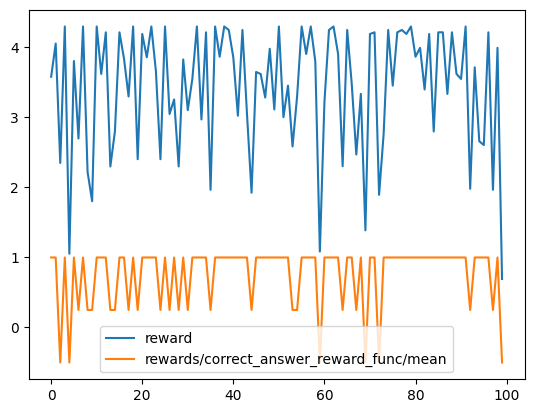

time: 135 ms (started: 2026-01-01 04:27:28 +00:00)


In [73]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

## View the results
Now let's try the model we just trained!

In [74]:
# === Save LoRA adapter + tokenizer (PEFT/Unsloth) ===
import os, glob

SAVE_DIR = "outputs/adapter_lora_final"
os.makedirs(SAVE_DIR, exist_ok=True)

# Lưu adapter (không phải full 3B params)
try:
    model.save_pretrained(SAVE_DIR, safe_serialization=True)   # tạo *.safetensors
except TypeError:
    model.save_pretrained(SAVE_DIR, use_safetensors=True)

# Lưu tokenizer (để giữ chat template)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved files:", os.listdir(SAVE_DIR))
print("Adapter weights:", [p for p in glob.glob(f"{SAVE_DIR}/*.safetensors")])


Saved files: ['tokenizer_config.json', 'adapter_model.safetensors', 'adapter_config.json', 'merges.txt', 'special_tokens_map.json', 'chat_template.jinja', 'added_tokens.json', 'README.md', 'tokenizer.json', 'vocab.json']
Adapter weights: ['outputs/adapter_lora_final/adapter_model.safetensors']
time: 2.51 s (started: 2026-01-01 04:27:28 +00:00)


In [75]:
# Create a function to run both the original model and the updated model
# No changes needed in this cell


def compare_old_and_new_model(messages):
    from vllm import SamplingParams

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    old = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
        )[0]
        .outputs[0]
        .text
    )

    new = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
            lora_request=model.load_lora("grpo_saved_lora"),
        )[0]
        .outputs[0]
        .text
    )

    print("===OLD===\n")
    print(old)

    print("\n\n===NEW===\n")
    print(new)


time: 939 µs (started: 2026-01-01 04:27:31 +00:00)


### Compare the old and new models on the letter-counting task

In [76]:
# Let's try spelling the first word from the dataset
# TODO: Fill out the areas where you find **********

# Load the first item from the dataset (index 0) and compare the old and new models
# **********


time: 49.5 ms (started: 2026-01-01 04:27:31 +00:00)


Our model is better at spelling and counter letters in words! Depending on your reward functions, the size of your model, and the amount of steps trained, results may vary.

For about an hour of training time, your model may not be perfect (or maybe it is), but it's definitely moving in the right direction!

### Make sure the model did not forget basic facts

In [77]:
# Let's see if the model still remembers some of the facts from its original training
# TODO: Fill out the areas where you find **********

# Ask both the old and new models a question the model is likely to know,
# e.g. a well-known capital city
# **********



time: 45.1 ms (started: 2026-01-01 04:27:31 +00:00)


Great job! Congrats on completing the project! 🎉🤗